# Arrival Delay Prediction using xGBoost

#### Load and Prepare the data

In [1]:
import pandas as pd

df = pd.read_csv('Exercise2BusData.csv')
df.head(10)

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412
5,01/05/2022 19:58,10033,41351,1,33,19,46,30,38.970588
6,01/05/2022 20:14,10033,44399,1,75,26,46,63,38.840580
7,01/05/2022 20:28,10033,41356,1,58,15,46,52,34.059701
8,01/05/2022 20:57,10033,44060,1,904,35,46,888,34.102941
9,01/05/2022 21:00,10033,41357,1,141,12,46,140,34.000000


In [2]:
df.shape

(2179, 9)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


In [4]:
df.describe()

,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
count,2179.0,2179.000000,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000
mean,10033.0,42255.504819,1.0,216.376319,27.023405,58.164296,200.402478,45.972240
std,0.0,1246.205733,0.0,181.194381,14.103575,7.008233,177.460222,6.517437
min,10033.0,41343.000000,1.0,-72.000000,0.000000,39.000000,-82.000000,27.605263
25%,10033.0,41358.000000,1.0,89.000000,19.000000,51.000000,77.000000,39.390890
50%,10033.0,41373.000000,1.0,175.000000,25.000000,62.000000,159.000000,48.671756
75%,10033.0,44059.000000,1.0,292.000000,33.000000,62.000000,275.500000,50.940968
max,10033.0,45917.000000,1.0,1365.000000,132.000000,103.000000,1364.000000,54.492647


In [5]:
df.isnull().sum()

Arrival_time             0
Stop_id                  0
Bus_id                   0
Line_id                  0
Arrival_delay            0
Dwell_time               0
Scheduled_travel_time    0
Upstream_stop_delay      0
Recurrent_delay          0
dtype: int64

In [6]:
df = df.iloc[:1000] #Consider only first 1000 rows

In [7]:
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)     # Dropping unnecessary columns

<Axes: xlabel='Arrival_delay', ylabel='Count'>

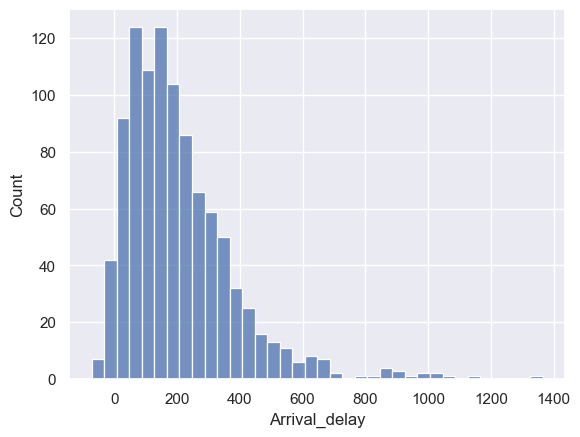

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

sns.histplot(x=df['Arrival_delay'])

In [9]:
#Influencce of input variables on 'Arrival_delay' column
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993908
Dwell_time               0.222777
Recurrent_delay          0.161830
Scheduled_travel_time    0.117362
Name: Arrival_delay, dtype: float64

c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


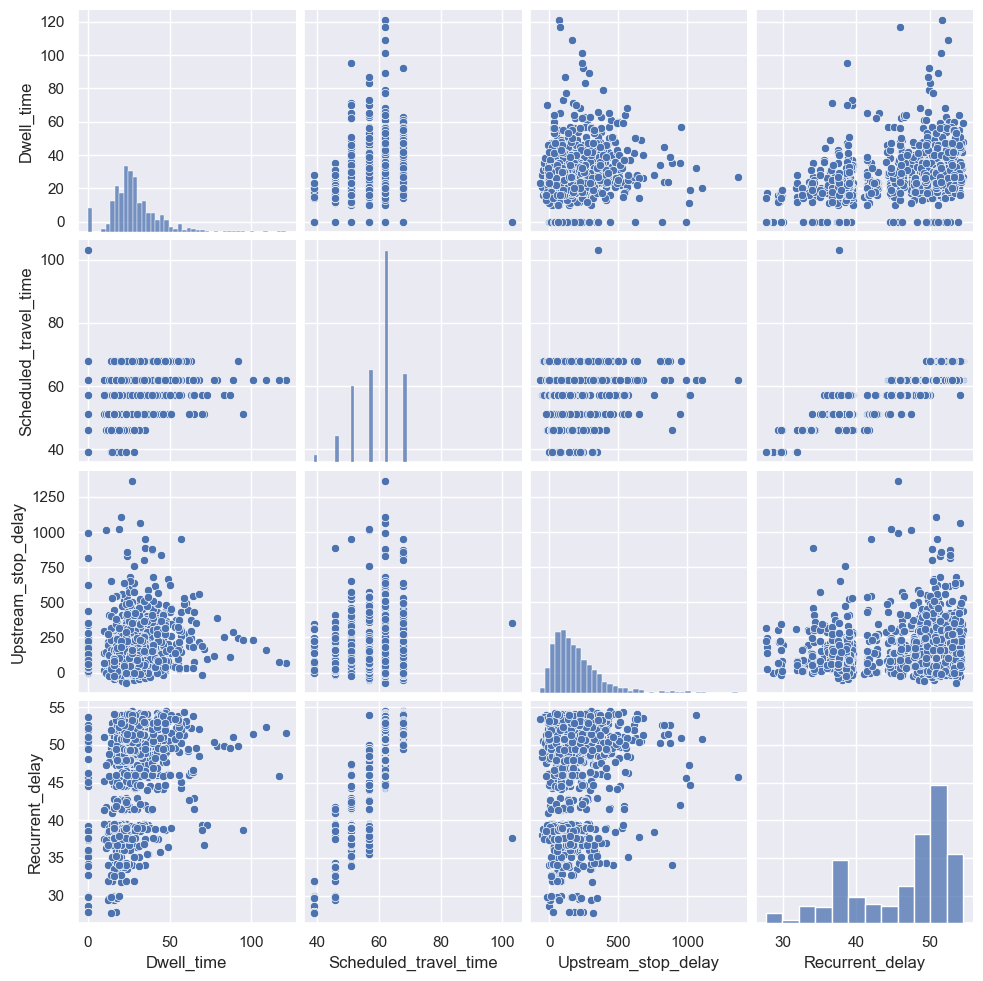

In [10]:
x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

sns.pairplot(x)

#### Creating the xGBoost model

##### Importing the required libraries

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import  GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True)

##### Normalisation

In [13]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Grid Search

In [14]:
# Timer function
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [15]:
from sklearn.model_selection import GridSearchCV

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.2,0.4,0.6],
        'colsample_bytree': [1,1.5,2],
        'max_depth': [7,15,25],
        'objective': ['reg:squarederror', 'reg:squaredlogerror','reg:logistic']
        }
        
#405 combinations of parameters

folds = 5
param_comb = 25 #choosing 100 combinations randomly out of 405

xgb = XGBRegressor(learning_rate = 1,n_estimators=2000, booster='gbtree',silent=True, nthread=1,random_state=42)

skf = KFold(n_splits=folds, shuffle = True, random_state = 1001)

grid_search = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_mean_squared_error', n_jobs=4, cv=skf.split(X_train_scaled,y_train), verbose=3 )

start_time = timer(None) # timing starts from this point for "start_time" variable
grid_search.fit(X_train_scaled,y_train)
timer(start_time) # timing ends here for "start_time" variable

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5400 fits failed out of a total of 6075.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\l

[15:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.


 Time taken: 0 hours 6 minutes and 54.32 seconds.
Best Parameters: {'colsample_bytree': 1, 'gamma': 1.5, 'max_depth': 15, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'subsample': 0.6}


##### Model With Best Parameters

In [16]:
# Create an SVR model with the best parameters from the grid search
best_xgb = XGBRegressor(colsample_bytree=best_params['colsample_bytree'], objective=best_params['objective'],gamma=best_params['gamma'], learning_rate=0.15, max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'], n_estimators=2000, subsample=best_params['subsample'], booster='gblinear', silent=True, nthread=1,random_state=42)

##### Cross Validation

In [17]:
# Perform cross-validation on the entire dataset
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_xgb, x , y, cv=5, verbose=2).mean()
print(cv_scores)

[15:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.

[CV] END .................................................... total time=   0.0s
[15:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.

[CV] END .................................................... total time=   0.0s
[15:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.

[CV] END ................

##### Model Fitting - Mean Square Error

In [18]:
early_stopping_rounds = 10
eval_metric = 'rmse'

best_xgb_mse =best_xgb.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric=eval_metric,
          early_stopping_rounds=early_stopping_rounds,
          verbose=False)
    
best_iteration = best_xgb_mse.best_iteration    #Boosting rounds

[15:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.



c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [19]:
y_test_pred = best_xgb_mse.predict(X_test)

Best Iteration: 1999
MSE - Testing Error: 168.00765065459885


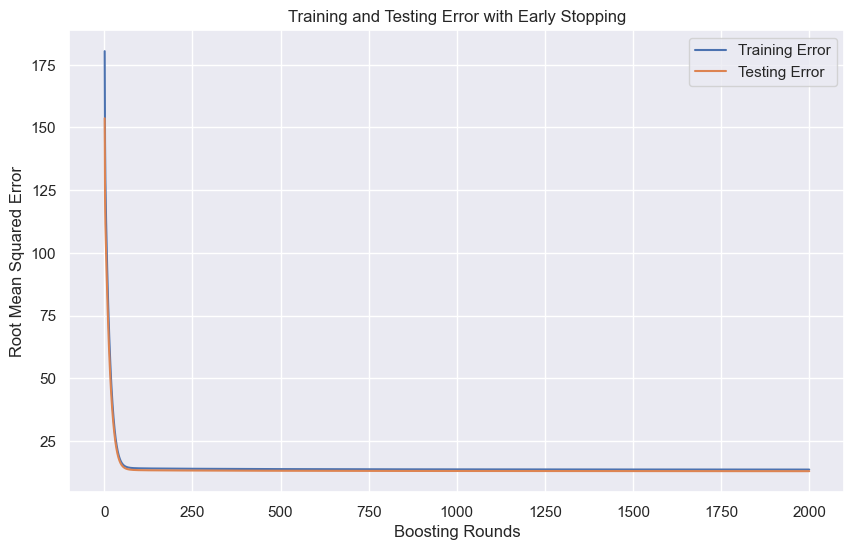

In [20]:
from sklearn.metrics import mean_squared_error

mse_train_errors = []
mse_test_errors = []


mse_test_error = mean_squared_error(y_test, y_test_pred)

print(f"Best Iteration: {best_iteration}")
print(f"MSE - Testing Error: {mse_test_error}")

results = best_xgb_mse.evals_result()
mse_train_errors = results["validation_0"]["rmse"]
mse_test_errors = results["validation_1"]["rmse"]
boosting_rounds = range(1, len(mse_train_errors) + 1)


plt.figure(figsize=(10, 6))
plt.plot(boosting_rounds, mse_train_errors, label="Training Error")
plt.plot(boosting_rounds, mse_test_errors, label="Testing Error")
plt.xlabel("Boosting Rounds")
plt.ylabel("Root Mean Squared Error")
plt.legend()
plt.title("Training and Testing Error with Early Stopping")
plt.show()

##### Model Fitting - Mean Absolute Error

In [21]:
early_stopping_rounds = 10
eval_metric = 'mae'

best_xgb_mae = best_xgb.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric=eval_metric,
          early_stopping_rounds=early_stopping_rounds,
          verbose=False)
    
best_iteration = best_xgb_mae.best_iteration    #Boosting rounds

c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Trisha Chander\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[15:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.



In [22]:
y_test_pred = best_xgb_mae.predict(X_test)

Best Iteration: 1999
MAE - Testing Error: 9.180392513275146


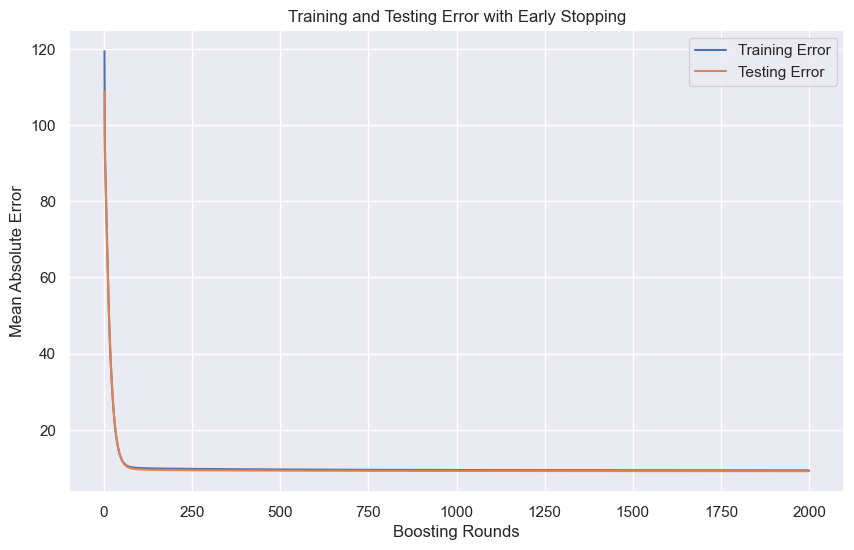

In [23]:
from sklearn.metrics import mean_absolute_error

mae_train_errors = []
mae_test_errors = []


mae_test_error = mean_absolute_error(y_test, y_test_pred)


print(f"Best Iteration: {best_iteration}")
print(f"MAE - Testing Error: {mae_test_error}")

results = best_xgb_mae.evals_result()
mae_train_errors = results["validation_0"]["mae"]
mae_test_errors = results["validation_1"]["mae"]
boosting_rounds = range(1, len(mae_test_errors) + 1)


plt.figure(figsize=(10, 6))
plt.plot(boosting_rounds, mae_train_errors, label="Training Error")
plt.plot(boosting_rounds, mae_test_errors, label="Testing Error")
plt.xlabel("Boosting Rounds")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.title("Training and Testing Error with Early Stopping")
plt.show()

##### Final Prediction

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=False) #RMSE
r2 = r2_score(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


[15:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "silent", "subsample" } are not used.

Mean Absolute Error: 9.180392513275146
Mean Squared Error: 12.961776523864268
R-squared: 0.993243128922734


##### Model Evaluation

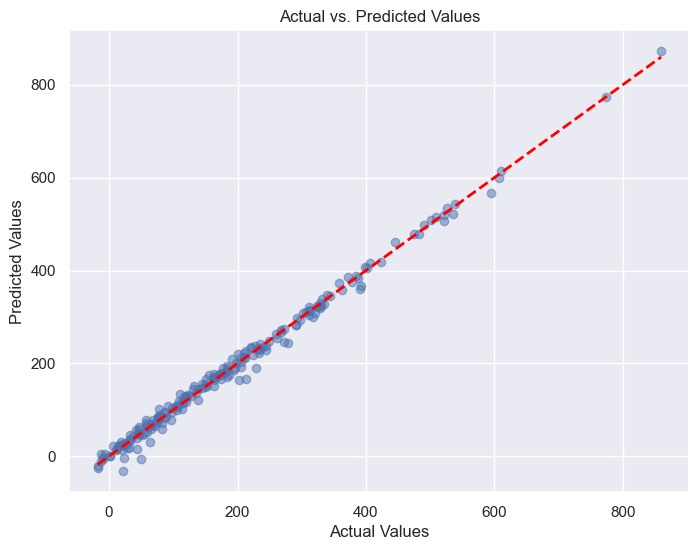

In [25]:
# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()